## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
CALLBACKS_PATIENCE = [10, 18, 25]
MIN_DELTA = [0, 0.5]

In [9]:
from keras.callbacks import EarlyStopping

results = {}
for cbp in CALLBACKS_PATIENCE:
    for md in MIN_DELTA:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with callbacks patience = %d, min_delta = %.2f" % (cbp, md))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()

        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        # 載入 Callbacks
        earlystop = EarlyStopping(monitor="val_acc",  # 被監測的數據
                                  min_delta=md,       # 增大或減小的閾值, 只有大於這個數值才算有提升 
                                                      # (小於 min_delta 的絻對變化會被認為沒有提升)
                                  patience=cbp,       # 能夠容忍多少個 epochs 沒有提升
                                  verbose=1
                                  )

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[earlystop]
                 )

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "cbp-%d, md=%.2f" % (cbp, md)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}  

Experiment with callbacks patience = 10, min_delta = 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 47us/step - loss: 1.5417 - acc: 0.4582 - val_loss: 1.6223 - val_acc: 0.4285
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4857 - acc: 0.4783 - val_loss: 1.5880 - val_acc: 0.4408
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4395 - acc: 0.4959 - val_loss: 1.5695 - val_acc: 0.4487
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.4014 - acc: 0.5101 - val_loss: 1.5543 - val_acc: 0.4564
Epoch 8/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3674 - acc: 0.5246 - val_loss: 1.5291 - val_acc: 0.4637
Epoch 9/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3359 - acc: 0.5351 - val_loss: 1.5103 - val_acc: 0.4640
Epoch 10/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3062 - acc: 0.5460 - val_loss: 1.5035 - val_acc: 0.4710
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 3s 52us/step - loss: 0.6640 - acc: 0.7927 - val_loss: 1.5527 - val_acc: 0.4940
Epoch 42/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.6460 - acc: 0.8006 - val_loss: 1.5798 - val_acc: 0.4934
Epoch 43/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.6272 - acc: 0.8074 - val_loss: 1.5811 - val_acc: 0.4917
Epoch 44/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.6105 - acc: 0.8139 - val_loss: 1.5933 - val_acc: 0.4942
Epoch 45/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.5924 - acc: 0.8226 - val_loss: 1.5996 - val_acc: 0.4980
Epoch 46/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.5766 - acc: 0.8284 - val_loss: 1.6142 - val_acc: 0.4927
Epoch 47/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.5591 - acc: 0.8350 - val_loss: 1.6168 - val_acc: 0.4959
Epoch 48/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 47us/step - loss: 1.3411 - acc: 0.5334 - val_loss: 1.5182 - val_acc: 0.4633
Epoch 10/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3115 - acc: 0.5441 - val_loss: 1.5113 - val_acc: 0.4635
Epoch 11/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2836 - acc: 0.5541 - val_loss: 1.4960 - val_acc: 0.4732
Epoch 12/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2572 - acc: 0.5658 - val_loss: 1.4831 - val_acc: 0.4739
Epoch 13/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2308 - acc: 0.5745 - val_loss: 1.4814 - val_acc: 0.4761
Epoch 14/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2065 - acc: 0.5834 - val_loss: 1.4750 - val_acc: 0.4781
Epoch 15/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.1828 - acc: 0.5920 - val_loss: 1.4752 - val_acc: 0.4771
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 47us/step - loss: 1.4035 - acc: 0.5100 - val_loss: 1.5493 - val_acc: 0.4565
Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3660 - acc: 0.5242 - val_loss: 1.5344 - val_acc: 0.4648
Epoch 9/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3334 - acc: 0.5370 - val_loss: 1.5178 - val_acc: 0.4650
Epoch 10/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3022 - acc: 0.5486 - val_loss: 1.4987 - val_acc: 0.4774
Epoch 11/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2756 - acc: 0.5574 - val_loss: 1.4930 - val_acc: 0.4774
Epoch 12/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2478 - acc: 0.5679 - val_loss: 1.4779 - val_acc: 0.4760
Epoch 13/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2218 - acc: 0.5783 - val_loss: 1.4779 - val_acc: 0.4799
Epoch 14/50
50000/50000 [=======================

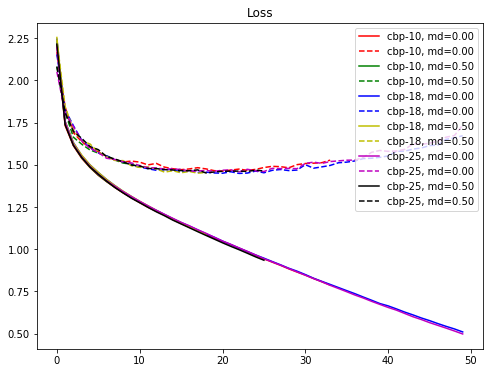

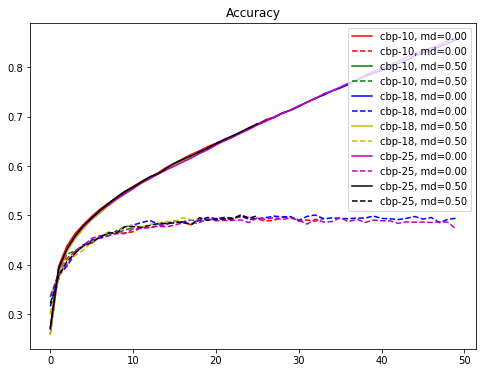

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()